# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder

from xgboost import plot_importance

import shap

import warnings
warnings.filterwarnings(action='ignore')

c:\Users\aryij\anaconda3\envs\football\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 경로
path = "data/df_eda.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,player_name,start_season,goals,assists,minutes_played,competition_code,date_of_birth,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
0,Aaron Connolly,2019,3,2,1261,premier-league,2000-01-28,20,Centre-Forward,Brighton and Hove Albion Football Club,4000000.0,Ireland,right,174.0
1,Aaron Connolly,2020,2,1,791,premier-league,2000-01-28,21,Centre-Forward,Brighton and Hove Albion Football Club,7000000.0,Ireland,right,174.0
2,Aaron Connolly,2021,0,0,155,premier-league,2000-01-28,22,Centre-Forward,Brighton and Hove Albion Football Club,6000000.0,Ireland,right,174.0
3,Aaron Cresswell,2019,3,0,2730,premier-league,1989-12-15,30,Left-Back,West Ham United Football Club,6500000.0,England,left,170.0
4,Aaron Cresswell,2020,0,8,3172,premier-league,1989-12-15,31,Left-Back,West Ham United Football Club,5000000.0,England,left,170.0


In [4]:
# date_of_birth 열 제거 (age로 대체)
df = df.drop("date_of_birth", axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              15999 non-null  object 
 1   start_season             15999 non-null  int64  
 2   goals                    15999 non-null  int64  
 3   assists                  15999 non-null  int64  
 4   minutes_played           15999 non-null  int64  
 5   competition_code         15999 non-null  object 
 6   age                      15999 non-null  int64  
 7   position                 15999 non-null  object 
 8   current_club_name        15999 non-null  object 
 9   market_value_per_season  15999 non-null  float64
 10  country                  15999 non-null  object 
 11  foot                     15999 non-null  object 
 12  height_in_cm             15999 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.6+ MB


In [6]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [7]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['start_season', 'goals', 'assists', 'minutes_played', 'age', 'market_value_per_season', 'height_in_cm']
범주형 변수 : ['player_name', 'competition_code', 'position', 'current_club_name', 'country', 'foot']


## 데이터 분리

In [8]:
# target 컬럼 "market_value_per_season"
target = "market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((13083, 13), (2916, 13))

In [9]:
# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [10]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10466, 12), (10466,), (2617, 12), (2617,), (2916, 12), (2916,))

In [11]:
num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# train 데이터 copy
X_train_no_enc = train[features].copy()
# y_train_no_enc = train[target].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()
# y_val_no_enc = val[target].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()
# y_test_no_enc = test[target].copy()

## 인코딩

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [12]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## 회귀모델 평가 지표  
- `RMSLE`
    - MSE에 루트를 씌운 RMSE의 각 인자에 로그를 취해준 값
        - 로그 변환을 통해 이상치에 대한 영향을 줄이고, 모델이 이상치에 대해 과도하게 페널티를 받지 않게 한다
        - 과소평가된 항목에 큰 패널티를 부여한다
        - 상대적 ERROR 측정
        - 값의 범위가 넓은 데이터에서 이상치에 대해 변화의 폭이 크지 않다
    - 정규 분포를 따르지 않고 불균형한 모형일 때 사용되는 방법

- `R2 Score` (결정 계수)
    - 종속 변수의 총 변동 중 모델이 설명하는 변동의 비율
    - 0 ~ 1 사이의 값을 가지며, 높을 수록 모델이 데이터를 잘 설명한다는 뜻

- 평가 지표 선정 이유
    - 예측하고자 하는 타겟에 이상치가 많이 존재한다 (`market_value_per_season`)
        - `RMSLE` : 이상치에 강건한 특성을 갖는다
            - 실제보다 작게 예측이 되었을 때 페널티를 더 크게 부여한다
            - 선수 몸값이 실제 몸값 보다 적게 측정된다면, 
                - Transfermarkt 웹사이트가 몸값을 부풀린다고 오해받을 수 있다 
                - 실제 이적시장에 거품이 많이 끼어있다고 생각할 수도 있다
            - 따라서 과소 평가 항목에 페널티를 주는 `RMSLE`를 통해 평가
        - `R2 Score` : 모델이 얼마나 데이터의 변동을 잘 설명하는지 평가

- References
    - https://shinminyong.tistory.com/32
    - https://wikidocs.net/219419
    - https://www.inflearn.com/questions/992421/rmsle%EC%9D%98-%EC%82%AC%EC%9A%A9%EC%97%90-%EA%B4%80%ED%95%9C-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4

In [13]:
def get_rmsle(y_actual, y_pred):
    # sklearn의 mean_square_log_error 함수는 y_pred 값 중 하나라도 0 미만인 경우 에러 발생
    # y_pred + 1 만들어 0보다 크게 만들어 준다 (음수가 되지 않게 방지)
    # 이후 optuna에 적용하여 RMSLE를 기준으로 하이퍼파라미터 튜닝
    
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()                 
    return np.sqrt(mean_error)   

In [14]:
# def rmsle(y, pred):
#     log_y = np.log1p(y)
#     log_pred = np.log1p(pred)
#     squared_error = (log_y-log_pred)**2
#     rmsle = np.sqrt(np.mean(squared_error))
#     return rmsle

## Baseline 모델 생성

In [15]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [16]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  347262606.98156476
Coefficients:


[('player_name', 0.5937233387317923),
 ('start_season', -167995.35551564215),
 ('goals', 673432.9348593699),
 ('assists', 751921.2259216892),
 ('minutes_played', 1685.0130094869426),
 ('competition_code', 0.1765412591776112),
 ('age', -291993.08863382915),
 ('position', 0.061714072787253826),
 ('current_club_name', 0.3928700765245594),
 ('country', 0.04409305842455069),
 ('foot', -1.6821105026862622),
 ('height_in_cm', 42635.17911879805)]

In [18]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)
    y_test_pred_lr = model.predict(X_test)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr, squared=False)
    base_rootMeanSqLogErr = get_rmsle(y_test, y_test_pred_lr)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "RMSLE" : '{:.2f}'.format(base_rootMeanSqLogErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [19]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Linear Regression,5367047.51,89344749369249.31,9452235.15,1.01,0.67


## 스케일링
- 데이터셋의 다양한 컬럼들에 이상치 다수 존재
    - 하지만 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라진다
    - 따라서 이상치 제거하지 않음
- `RobustScaler` 선택 (이상치의 영향 최소화)
- References
    - https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
    - IQR = Q3 - Q1 : 25퍼센타일과 75퍼센타일의 값들
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다
- 이번에는 사용하지 않는다
    - Tree 기반 모델에서는 스케일링이 큰 효과가 없기 때문

In [20]:
# # RobustScaler X_train 데이터셋에 fit
# robustScaler = RobustScaler().fit(X_train)

# # RobustScaler로 X_train, X_val, X_test 데이터셋 변환
# X_train_robust = robustScaler.transform(X_train)
# X_val_robust = robustScaler.transform(X_val)
# X_test_robust = robustScaler.transform(X_test)

## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [21]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [22]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [23]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
        meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
        rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [24]:
# Top 3 : Random Forest, LightGBM, CatBoost, XGBoost순으로 RMSLE 높다
model_list(models)

Learning rate set to 0.059334
0:	learn: 13830800.2476729	total: 135ms	remaining: 2m 14s
1:	learn: 13357703.3126133	total: 138ms	remaining: 1m 8s
2:	learn: 12922486.5872620	total: 140ms	remaining: 46.6s
3:	learn: 12487160.3776749	total: 143ms	remaining: 35.5s
4:	learn: 12093755.5470775	total: 145ms	remaining: 28.9s
5:	learn: 11703798.1034282	total: 148ms	remaining: 24.5s
6:	learn: 11358117.0622625	total: 151ms	remaining: 21.4s
7:	learn: 11036272.4592914	total: 153ms	remaining: 19s
8:	learn: 10711262.9457120	total: 156ms	remaining: 17.2s
9:	learn: 10440591.2339328	total: 159ms	remaining: 15.7s
10:	learn: 10197633.4834545	total: 161ms	remaining: 14.5s
11:	learn: 9962018.0274968	total: 164ms	remaining: 13.5s
12:	learn: 9705643.3608356	total: 168ms	remaining: 12.7s
13:	learn: 9484336.7543583	total: 171ms	remaining: 12s
14:	learn: 9291941.2499728	total: 174ms	remaining: 11.4s
15:	learn: 9095609.3228752	total: 176ms	remaining: 10.8s
16:	learn: 8911766.5975728	total: 178ms	remaining: 10.3s
17:

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Random Forest,4199426.87,68593476438936.03,8282117.87,0.65,0.75
1,LightGBM,3880224.80,54696393930066.98,7395701.04,0.69,0.80
2,XGBoost,3972273.43,54660632274491.61,7393282.92,0.72,0.80
3,CatBoost,3727128.77,49483329105684.12,7034438.79,0.74,0.82
4,Decision Tree,5600848.77,118385415166323.73,10880506.20,0.89,0.57
5,Linear Regression,5367047.51,89344749369249.31,9452235.15,1.01,0.67


In [25]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models):
    models_results = []

    for model_name, model in models:

        if model_name == "CatBoost":

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 생성 및 훈련
            model.fit(X_train_no_enc, y_train, cat_features=cat_features)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)
            y_test_pred_cat = model.predict(X_test_no_enc)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_test, y_test_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat)
            rootMeanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat, squared=False)
            rootMeanSqLogErr_cat = get_rmsle(y_test, y_test_pred_cat)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test_no_enc, y_test))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
            meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
            rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
            rootMeanSqLogErr = get_rmsle(y_test, y_test_pred)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "RMSLE" : '{:.2f}'.format(rootMeanSqLogErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models before Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [26]:
model_list2(models)

Learning rate set to 0.059334
0:	learn: 13930548.5583636	total: 34.3ms	remaining: 34.3s
1:	learn: 13577890.4655601	total: 71.6ms	remaining: 35.7s
2:	learn: 13222271.2793252	total: 111ms	remaining: 37s
3:	learn: 12899943.7729440	total: 148ms	remaining: 36.8s
4:	learn: 12623886.1740279	total: 185ms	remaining: 36.9s
5:	learn: 12340601.2050759	total: 220ms	remaining: 36.5s
6:	learn: 12095714.7281121	total: 253ms	remaining: 35.8s
7:	learn: 11858503.2699037	total: 282ms	remaining: 34.9s
8:	learn: 11636685.6397711	total: 312ms	remaining: 34.4s
9:	learn: 11439067.5152900	total: 346ms	remaining: 34.3s
10:	learn: 11240777.4448081	total: 377ms	remaining: 33.9s
11:	learn: 11059435.8285289	total: 407ms	remaining: 33.5s
12:	learn: 10898438.6546236	total: 437ms	remaining: 33.2s
13:	learn: 10741650.7373015	total: 469ms	remaining: 33s
14:	learn: 10582372.9299953	total: 498ms	remaining: 32.7s
15:	learn: 10423272.4012737	total: 528ms	remaining: 32.5s
16:	learn: 10286684.8161792	total: 558ms	remaining: 32

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,Random Forest,4199426.87,68593476438936.03,8282117.87,0.65,0.75
1,LightGBM,3880224.80,54696393930066.98,7395701.04,0.69,0.80
2,XGBoost,3972273.43,54660632274491.61,7393282.92,0.72,0.80
3,CatBoost,4174150.13,63399948620137.79,7962408.47,0.76,0.77
4,Decision Tree,5600848.77,118385415166323.73,10880506.20,0.89,0.57
5,Linear Regression,5367047.51,89344749369249.31,9452235.15,1.01,0.67


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거친 데이터셋으로 진행(`model_list` 함수)한 `CatBoost`가 더 낮은 `RMSLE` 기록

    - **0.73 vs 0.84** (Target Encoding 실행한 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- `RMSLE`가 낮은 `Random Forest`, `CatBoost`, `LightGBM`, `XGBoost` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 `RMSLE`보다 낮다 (0.98)

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


In [27]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

#### `Random Forest`

In [28]:
def objective_rf(trial):
    params = {
        # "iterations": 1000,
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "max_samples": trial.suggest_float("max_samples", 0.05, 1.0),
        "max_features": trial.suggest_float("max_features", 0.05, 1.0),
        "min_weight_fraction_leaf": trial.suggest_int("min_weight_fraction_leaf", 0.05, 0.5),
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [29]:
study_rf = optuna.create_study(direction='minimize', sampler=sampler)
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-05-12 20:29:38,014] A new study created in memory with name: no-name-53a3ce76-2e43-4de7-996b-7c74b09d0e0d
[I 2024-05-12 20:30:09,331] Trial 0 finished with value: 0.6975107591356479 and parameters: {'n_estimators': 1811, 'max_depth': 10, 'max_samples': 0.7453942447208348, 'max_features': 0.6187255599871848, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.6975107591356479.
[I 2024-05-12 20:30:11,634] Trial 1 finished with value: 1.1595879913113714 and parameters: {'n_estimators': 1046, 'max_depth': 2, 'max_samples': 0.10517943155978948, 'max_features': 0.8728673384861885, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.6975107591356479.
[I 2024-05-12 20:30:22,084] Trial 2 finished with value: 0.7732653872695374 and parameters: {'n_estimators': 2604, 'max_depth': 8, 'max_samples': 0.06955526958101232, 'max_features': 0.9714143595538947, 'min_weight_fraction_leaf': 0}. Best is trial 0 with value: 0.6975107591356479.
[I 2024-05-12 20:30:28,130] Trial 3 f

In [30]:
print("Best hyperparameters:", study_rf.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_rf.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 631, 'max_depth': 10, 'max_samples': 0.9390046689278375, 'max_features': 0.7376193928070954, 'min_weight_fraction_leaf': 0}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.69465994281129


In [31]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_rf)

In [32]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_rf)

In [33]:
rf_optuna = RandomForestRegressor(**study_rf.best_params)
model_list([("RandomForest_tuned", rf_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,RandomForest_tuned,4314788.99,70506305803398.89,8396803.31,0.69,0.74


#### `CatBoost`

In [34]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [35]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-05-12 20:38:46,910] A new study created in memory with name: no-name-bf308c35-6a75-4fdd-a632-b75c986375e5


[I 2024-05-12 20:38:48,070] Trial 0 finished with value: 0.92993956901987 and parameters: {'n_estimators': 927, 'learning_rate': 0.009780337016659405, 'depth': 1, 'subsample': 0.9138543819748429, 'colsample_bylevel': 0.29584098252001606, 'min_data_in_leaf': 67}. Best is trial 0 with value: 0.92993956901987.
[I 2024-05-12 20:38:52,532] Trial 1 finished with value: 0.7010139847811233 and parameters: {'n_estimators': 1591, 'learning_rate': 0.010968217207529524, 'depth': 6, 'subsample': 0.22561173274925067, 'colsample_bylevel': 0.9711053963763306, 'min_data_in_leaf': 78}. Best is trial 1 with value: 0.7010139847811233.
[I 2024-05-12 20:38:59,378] Trial 2 finished with value: 0.7514566004672186 and parameters: {'n_estimators': 3789, 'learning_rate': 0.06161049539380966, 'depth': 6, 'subsample': 0.925780523271961, 'colsample_bylevel': 0.13406787694932354, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.7010139847811233.
[I 2024-05-12 20:39:00,741] Trial 3 finished with value: 0.960828

In [36]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 940, 'learning_rate': 0.023152906583498525, 'depth': 9, 'subsample': 0.3201012976753739, 'colsample_bylevel': 0.4050931876862345, 'min_data_in_leaf': 20}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6423127877354567


In [37]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [38]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [39]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list([("CatBoost_tuned", cat_optuna)], "After")

0:	learn: 14134287.3155772	total: 7.81ms	remaining: 7.33s
1:	learn: 13952371.7553692	total: 23.8ms	remaining: 11.2s
2:	learn: 13759849.1736415	total: 34.1ms	remaining: 10.6s
3:	learn: 13567769.7270536	total: 41.4ms	remaining: 9.68s
4:	learn: 13401280.7454485	total: 51.3ms	remaining: 9.59s
5:	learn: 13221776.3055441	total: 58ms	remaining: 9.03s
6:	learn: 13038708.7906264	total: 67.1ms	remaining: 8.95s
7:	learn: 12871424.2299574	total: 74.3ms	remaining: 8.66s
8:	learn: 12693936.6145597	total: 84.3ms	remaining: 8.72s
9:	learn: 12519237.8278544	total: 90.3ms	remaining: 8.4s
10:	learn: 12353353.0358067	total: 99ms	remaining: 8.36s
11:	learn: 12183932.4781118	total: 106ms	remaining: 8.18s
12:	learn: 12023317.1849084	total: 114ms	remaining: 8.1s
13:	learn: 11870757.1946311	total: 122ms	remaining: 8.05s
14:	learn: 11724818.2085006	total: 131ms	remaining: 8.1s
15:	learn: 11578598.7709454	total: 139ms	remaining: 8.04s
16:	learn: 11448382.2655006	total: 148ms	remaining: 8.01s
17:	learn: 11322091.

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,CatBoost_tuned,3620686.62,50082968128629.12,7076932.11,0.64,0.82


#### `XGBoost`

In [40]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)

    return rmsle

In [41]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-05-12 20:44:41,258] A new study created in memory with name: no-name-1333f5c0-12fe-4c68-a7fe-3405bb7f219b
[I 2024-05-12 20:44:43,611] Trial 0 finished with value: 0.7050247574495496 and parameters: {'n_estimators': 610, 'learning_rate': 0.0187422109855557, 'max_depth': 4, 'subsample': 0.5331421566064676, 'colsample_bytree': 0.9121881502297884, 'min_child_weight': 5}. Best is trial 0 with value: 0.7050247574495496.
[I 2024-05-12 20:44:47,006] Trial 1 finished with value: 0.8560890185848851 and parameters: {'n_estimators': 1936, 'learning_rate': 0.03244160088734161, 'max_depth': 3, 'subsample': 0.12313091433735335, 'colsample_bytree': 0.3252638802680796, 'min_child_weight': 4}. Best is trial 0 with value: 0.7050247574495496.
[I 2024-05-12 20:45:07,750] Trial 2 finished with value: 0.6987939140831612 and parameters: {'n_estimators': 3754, 'learning_rate': 0.04132765459466366, 'max_depth': 7, 'subsample': 0.8778875606783318, 'colsample_bytree': 0.8134884730541587, 'min_child_weight

In [42]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 1245, 'learning_rate': 0.005338679492821957, 'max_depth': 9, 'subsample': 0.47657941438505813, 'colsample_bytree': 0.7050046907622647, 'min_child_weight': 18}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.6378120512054563


In [43]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [44]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [45]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list([("XGBoost_tuned", xgb_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,XGBoost_tuned,3839750.82,59691794416657.45,7726046.49,0.63,0.78


#### `LightGBM`

In [46]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmsle = get_rmsle(y_test, predictions)


    return rmsle

In [47]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-05-12 20:49:01,501] A new study created in memory with name: no-name-9f88dacd-0d10-4116-a89c-1d36a37f116f


[I 2024-05-12 20:49:05,005] Trial 0 finished with value: 0.8323080127110625 and parameters: {'n_estimators': 1787, 'learning_rate': 0.018391267498289014, 'num_leaves': 650, 'subsample': 0.5589859498710206, 'colsample_bytree': 0.1357752815516879, 'min_data_in_leaf': 84}. Best is trial 0 with value: 0.8323080127110625.
[I 2024-05-12 20:49:07,747] Trial 1 finished with value: 0.7313443310728845 and parameters: {'n_estimators': 1623, 'learning_rate': 0.0023606794572813066, 'num_leaves': 43, 'subsample': 0.6113482960288298, 'colsample_bytree': 0.6936861437501683, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.7313443310728845.
[I 2024-05-12 20:49:11,920] Trial 2 finished with value: 0.6664629796192838 and parameters: {'n_estimators': 2292, 'learning_rate': 0.002837863814617626, 'num_leaves': 662, 'subsample': 0.21564810755474184, 'colsample_bytree': 0.7063908511973427, 'min_data_in_leaf': 39}. Best is trial 2 with value: 0.6664629796192838.
[I 2024-05-12 20:49:15,226] Trial 3 finishe

In [48]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSLE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3162, 'learning_rate': 0.002483285435681272, 'num_leaves': 100, 'subsample': 0.6590829870608579, 'colsample_bytree': 0.7800080912868288, 'min_data_in_leaf': 56}
-----------------------------------------------------------------------------------------------------------------
Best RMSLE:
0.626879511370602


In [49]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [50]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [51]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list([("LightGBM_tuned", lgbm_optuna)], "After")

[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 10466, number of used features: 12
[LightGBM] [Info] Start training from score 8995590.483470
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is set=56, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=56
[LightGBM] [Warning] min_data_in_leaf is s

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,LightGBM_tuned,3853679.65,60814712238048.47,7798378.82,0.64,0.78


#### 튜닝한 모델들 비교

In [52]:
models_tuned = models = [
    ("RandomForest_tuned", rf_optuna),
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgbm_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [53]:
model_list(models_tuned, "After")

0:	learn: 14134287.3155772	total: 6.67ms	remaining: 6.26s
1:	learn: 13952371.7553692	total: 16.7ms	remaining: 7.84s
2:	learn: 13759849.1736415	total: 25.2ms	remaining: 7.87s
3:	learn: 13567769.7270536	total: 33.6ms	remaining: 7.87s
4:	learn: 13401280.7454485	total: 42.2ms	remaining: 7.89s
5:	learn: 13221776.3055441	total: 49.8ms	remaining: 7.76s
6:	learn: 13038708.7906264	total: 57.8ms	remaining: 7.71s
7:	learn: 12871424.2299574	total: 66.8ms	remaining: 7.78s
8:	learn: 12693936.6145597	total: 77ms	remaining: 7.96s
9:	learn: 12519237.8278544	total: 84.1ms	remaining: 7.82s
10:	learn: 12353353.0358067	total: 94.8ms	remaining: 8.01s
11:	learn: 12183932.4781118	total: 102ms	remaining: 7.88s
12:	learn: 12023317.1849084	total: 108ms	remaining: 7.72s
13:	learn: 11870757.1946311	total: 117ms	remaining: 7.72s
14:	learn: 11724818.2085006	total: 126ms	remaining: 7.78s
15:	learn: 11578598.7709454	total: 134ms	remaining: 7.74s
16:	learn: 11448382.2655006	total: 142ms	remaining: 7.72s
17:	learn: 1132

,Model,MAE,MSE,RMSE,RMSLE,R2 Score
0,XGBoost_tuned,3839750.82,59691794416657.45,7726046.49,0.63,0.78
1,CatBoost_tuned,3620686.62,50082968128629.12,7076932.11,0.64,0.82
2,LightGBM_tuned,3853679.65,60814712238048.47,7798378.82,0.64,0.78
3,RandomForest_tuned,4325417.57,70855410663501.44,8417565.60,0.69,0.74


##### 모델별 최적의 하이퍼파라미터

In [54]:
best_params_rf = {'n_estimators': 631, 
                  'max_depth': 10, 
                  'max_samples': 0.9390046689278375, 
                  'max_features': 0.7376193928070954, 
                  'min_weight_fraction_leaf': 0}

best_params_cat = {'n_estimators': 940, 
                   'learning_rate': 0.023152906583498525, 
                   'depth': 9, 
                   'subsample': 0.3201012976753739, 
                   'colsample_bylevel': 0.4050931876862345, 
                   'min_data_in_leaf': 20}

best_params_xgb = {'n_estimators': 1245, 
                   'learning_rate': 0.005338679492821957, 
                   'max_depth': 9, 
                   'subsample': 0.47657941438505813, 
                   'colsample_bytree': 0.7050046907622647, 
                   'min_child_weight': 18}

best_params_lgbm = {'n_estimators': 3162, 
                    'learning_rate': 0.002483285435681272, 
                    'num_leaves': 100, 
                    'subsample': 0.6590829870608579, 
                    'colsample_bytree': 0.7800080912868288, 
                    'min_data_in_leaf': 56}

### 최적화 후 모델 재생성
- `XGBoost` : 가장 작은 `RMSLE` 기록
    - RMSLE : 0.63
    - R2 Score : 0.78
- `CatBoost` : 가장 높은 `R2 Score` 기록
    - RMSLE : 0.64
    - R@ Score : 0.82

In [55]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, xgb 모델 생성
xgb_optuna.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7050046907622647, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005338679492821957,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=18, missing=nan, monotone_constraints=None,
             n_estimators=1245, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Feature Importance 확인
- player_name, goals, current_club_name, assists 순서
    - `player_name` : 선수 이름에 따라 몸값이 다르게 매겨지기 때문에 가장 크게 나온 것으로 보인다
    - `goals`
    - `current_club_name` : 소속 팀에 따라 가치가 매겨지는 경우가 있어서 중요도 있는 것으로 나옴 (ex. 빅클럽 이적)
    - `assists`

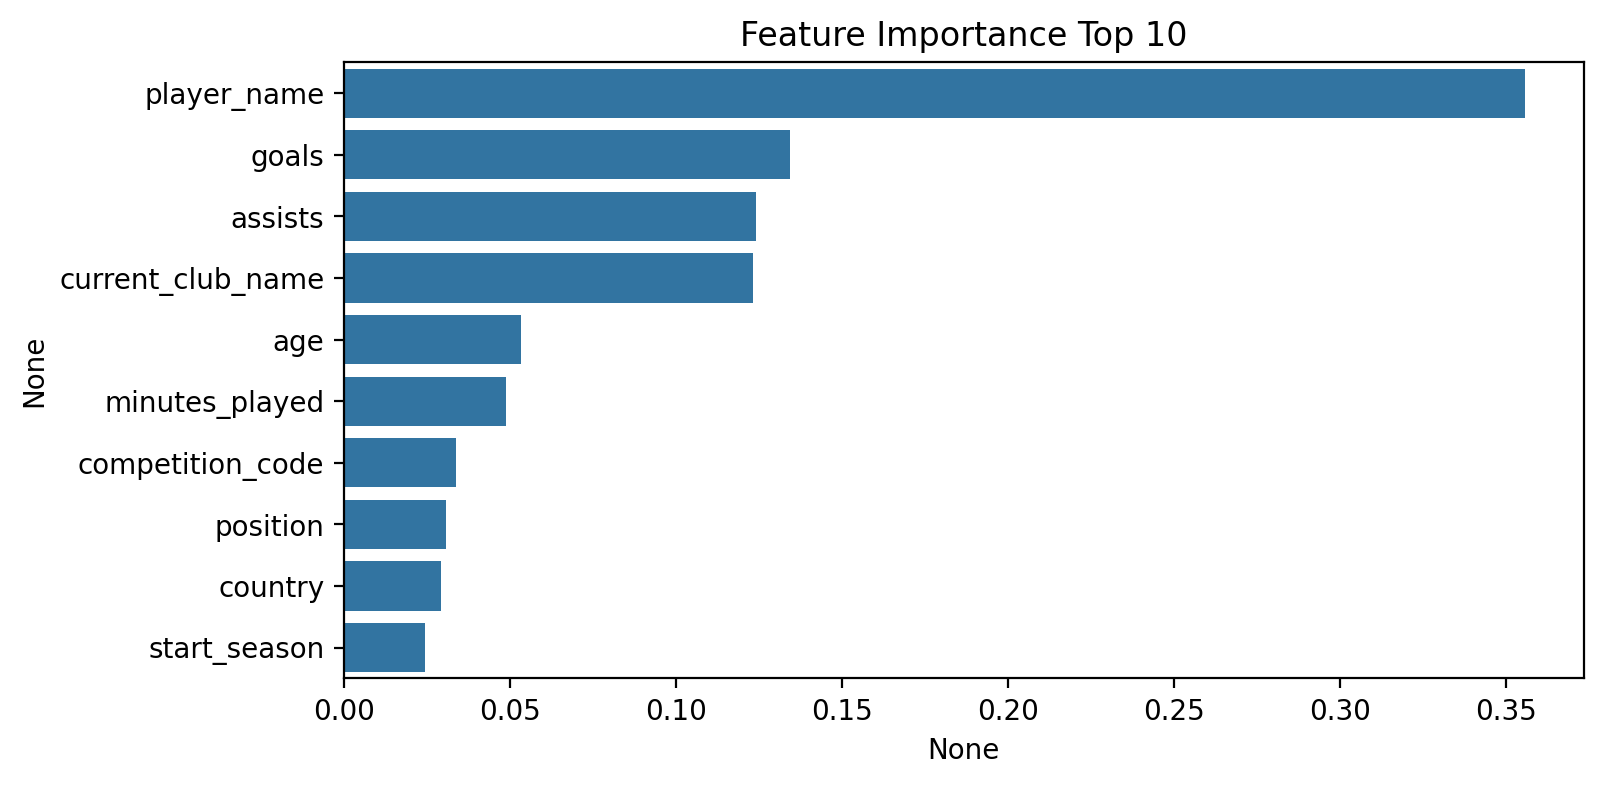

In [56]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = xgb_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

### `XGBoost` 모델로 예측한 test 값을 y_test 값과 비교

In [74]:
# test 데이터프레임 copy
test_copy_xgb = test.copy()

# xgb_optuna 모델로 예측한 X_test의 몸값을 담은 컬럼을 test_copy에 생성
test_copy_xgb["market_value_pred"] = xgb_optuna.predict(X_test)

In [75]:
# get_rmsle 함수 활용하여, 실제 몸값과 예측 몸값의 차이 RMSLE 계산한 컬럼 생성
test_copy_xgb['market_value_rmsle'] = test_copy_xgb.apply(lambda x:get_rmsle(x["market_value_per_season"], x["market_value_pred"]), axis=1)

In [76]:
test_copy_xgb = test_copy_xgb[['player_name', 'market_value_per_season', 'market_value_pred', 'market_value_rmsle',
                       'start_season', 'goals', 'assists', 'minutes_played',
                       'competition_code', 'age', 'position', 'current_club_name', 'country', 
                       'foot', 'height_in_cm']]

In [77]:
pd.options.display.float_format = '{:.2f}'.format

In [78]:
test_copy_xgb.describe()

,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,age,height_in_cm
count,2916.00,2916.00,2903.00,2916.00,2916.00,2916.00,2916.00,2916.00,2916.00
mean,10746150.55,9572428.00,0.47,2023.00,1.75,1.35,1242.71,26.22,182.77
std,16543013.03,12551638.00,0.42,0.00,3.13,2.01,868.15,4.39,6.75
min,50000.00,-764650.44,0.00,2023.00,0.00,0.00,1.00,16.00,163.00
25%,1700000.00,2241690.25,0.16,2023.00,0.00,0.00,451.50,23.00,178.00
50%,4500000.00,4960468.75,0.35,2023.00,1.00,1.00,1178.00,26.00,183.00
75%,13000000.00,11673470.00,0.64,2023.00,2.00,2.00,1942.25,29.00,188.00
max,180000000.00,116938584.00,3.83,2023.00,36.00,14.00,3240.00,41.00,206.00


In [79]:
# RMSLE 값이 0.05 이하인 예측 값 확인
test_copy_xgb[test_copy_xgb.market_value_rmsle <= 0.05].sort_values(by="market_value_per_season", ascending=False).head(20)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
5627,Harry Kane,110000000.00,111698504.00,0.02,2023,36,8,2843,bundesliga,30,Centre-Forward,FC Bayern München,England,right,188.00
7709,Julián Álvarez,90000000.00,90180120.00,0.00,2023,10,9,2650,premier-league,24,Second Striker,Manchester City Football Club,Argentina,right,170.00
8581,Leroy Sané,70000000.00,69747992.00,0.00,2023,8,11,2137,bundesliga,28,Right Winger,FC Bayern München,Germany,left,183.00
3200,Darwin Núñez,70000000.00,70615416.00,0.01,2023,11,8,2011,premier-league,24,Centre-Forward,Liverpool Football Club,Uruguay,right,187.00
2111,Bruno Fernandes,70000000.00,72835856.00,0.04,2023,10,7,2970,premier-league,29,Attacking Midfield,Manchester United Football Club,Portugal,right,179.00
11596,Ollie Watkins,65000000.00,65060764.00,0.00,2023,19,12,3068,premier-league,28,Centre-Forward,Aston Villa Football Club,England,right,180.00
3350,Dayot Upamecano,50000000.00,49242968.00,0.02,2023,1,0,1590,bundesliga,25,Centre-Back,FC Bayern München,France,right,186.00
7653,Jules Koundé,50000000.00,52263056.00,0.04,2023,1,2,2539,laliga,25,Centre-Back,Futbol Club Barcelona,France,right,180.00
2065,Brennan Johnson,48000000.00,49321336.00,0.03,2023,5,8,1823,premier-league,22,Right Winger,Tottenham Hotspur Football Club,Wales,right,186.00
13766,Serge Gnabry,45000000.00,44091620.00,0.02,2023,3,2,433,bundesliga,28,Right Winger,FC Bayern München,Germany,right,176.00


In [80]:
# RMSLE 값이 0.64 (75%) 이상인 예측 값 확인
# RMSLE 값 최대치 : 약 3.83

test_copy_xgb[test_copy_xgb.market_value_rmsle >= 0.64].sort_values(by="market_value_rmsle", ascending=False).head(10)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
711,Alfie Gilchrist,300000.00,13825467.00,3.83,2023,1,0,202,premier-league,20,Centre-Back,Chelsea Football Club,England,right,183.00
6410,James Tomkins,700000.00,26270.54,3.28,2023,0,0,5,premier-league,35,Centre-Back,Crystal Palace Football Club,England,right,192.00
13489,Samu Omorodion,40000000.00,1676623.38,3.17,2023,1,0,82,laliga,20,Centre-Forward,Deportivo Alavés S.A.D.,Spain,right,193.00
14205,Steven Baseya,50000.00,1016353.50,3.01,2023,0,0,5,ligue-1,19,Centre-Back,Racing Club de Strasbourg Alsace,France,right,189.00
11566,Oliver Arblaster,450000.00,8046924.50,2.88,2023,0,0,821,premier-league,20,Central Midfield,Sheffield United Football Club,England,right,180.00
11782,Papa Amadou Diallo,250000.00,3568358.75,2.66,2023,2,0,710,ligue-1,19,Left Winger,Football Club de Metz,Senegal,right,182.00
4921,Fred Onyedinma,500000.00,6944979.50,2.63,2023,0,0,334,premier-league,27,Attacking Midfield,Luton Town Football Club,Nigeria,right,185.00
9135,Luke Berry,400000.00,5465769.00,2.61,2023,2,1,308,premier-league,31,Central Midfield,Luton Town Football Club,England,right,177.00
8972,Luck Zogbé,100000.00,1082397.50,2.38,2023,0,0,10,ligue-1,19,Right-Back,Stade brestois 29,Cote d'Ivoire,right,178.00
14949,Unai Marrero,300000.00,3239567.00,2.38,2023,0,0,141,laliga,22,Goalkeeper,Real Sociedad de Fútbol S.A.D.,Spain,right,189.00


In [81]:
# RMSLE 값이 0.64 (75%) 이상인 예측 값 확인
# RMSLE 값 최대치 : 약 3.83

test_copy_xgb[test_copy_xgb.market_value_rmsle >= 0.64].sort_values(by="market_value_rmsle", ascending=False).tail(10)


,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7075,Jonathan Clauss,15000000.00,7857662.50,0.65,2023,3,2,1914,ligue-1,31,Right-Back,Olympique de Marseille,France,right,178.00
3758,Donny van de Beek,7000000.00,13355163.00,0.65,2023,0,0,357,bundesliga,27,Central Midfield,Eintracht Frankfurt Fußball AG,Netherlands,right,184.00
1829,Benson Manuel,6000000.00,3149801.50,0.64,2023,0,0,92,premier-league,27,Right Winger,Burnley Football Club,Belgium,left,166.00
13965,Simon Kjaer,2000000.00,3808230.00,0.64,2023,0,1,1169,serie-a,35,Centre-Back,Associazione Calcio Milan,Denmark,right,191.00
13123,Roman Yaremchuk,4000000.00,7611204.00,0.64,2023,3,0,796,laliga,28,Centre-Forward,Valencia Club de Fútbol S. A. D.,Ukraine,right,191.00
973,Andrea Petagna,5000000.00,9507698.00,0.64,2023,1,1,997,serie-a,28,Centre-Forward,Cagliari Calcio,Italy,left,190.00
2648,Christopher Nkunku,70000000.00,36829252.00,0.64,2023,2,0,333,premier-league,26,Attacking Midfield,Chelsea Football Club,France,right,177.00
10815,Moritz Nicolas,2000000.00,3800011.25,0.64,2023,0,0,2430,bundesliga,26,Goalkeeper,Borussia Verein für Leibesübungen 1900 Mönchen...,Germany,right,193.00
15443,Wout Weghorst,7000000.00,13294334.00,0.64,2023,7,3,1980,bundesliga,31,Centre-Forward,TSG 1899 Hoffenheim Fußball-Spielbetriebs GmbH,Netherlands,right,197.00
2996,Dani Parejo,3000000.00,5693035.00,0.64,2023,3,5,2334,laliga,35,Central Midfield,Villarreal Club de Fútbol S.A.D.,Spain,right,182.00


In [82]:
# Arsenal 선수들의 2324 시즌 몸값 비교
test_copy_xgb[test_copy_xgb.current_club_name=="Arsenal Football Club"].sort_values("market_value_rmsle").head(10)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
10720,Mohamed Elneny,4500000.00,4399555.00,0.02,2023,0,0,25,premier-league,31,Defensive Midfield,Arsenal Football Club,Egypt,right,179.00
12641,Reiss Nelson,15000000.00,14280841.00,0.05,2023,0,0,257,premier-league,24,Right Winger,Arsenal Football Club,England,right,175.00
8492,Leandro Trossard,38000000.00,40276092.00,0.06,2023,11,1,1502,premier-league,29,Left Winger,Arsenal Football Club,Belgium,right,172.00
3850,Eddie Nketiah,30000000.00,28169056.00,0.06,2023,5,2,1072,premier-league,24,Centre-Forward,Arsenal Football Club,England,right,175.00
4980,Fábio Vieira,25000000.00,23328020.00,0.07,2023,1,2,292,premier-league,23,Attacking Midfield,Arsenal Football Club,Portugal,left,170.00
7243,Jorginho,15000000.00,16667352.00,0.11,2023,0,2,919,premier-league,32,Defensive Midfield,Arsenal Football Club,Italy,right,178.00
6353,Jakub Kiwior,25000000.00,22267338.00,0.12,2023,1,3,944,premier-league,24,Left-Back,Arsenal Football Club,Poland,left,189.00
1758,Ben White,55000000.00,62565724.00,0.13,2023,4,4,2836,premier-league,26,Right-Back,Arsenal Football Club,England,right,186.00
4067,Emile Smith Rowe,25000000.00,29130590.00,0.15,2023,0,2,325,premier-league,23,Attacking Midfield,Arsenal Football Club,England,right,182.00
14537,Thomas Partey,20000000.00,23930734.00,0.18,2023,0,0,630,premier-league,30,Defensive Midfield,Arsenal Football Club,Ghana,right,185.00


In [83]:
# Tottenham 선수들의 2324 시즌 몸값 비교
test_copy_xgb[test_copy_xgb.current_club_name=="Tottenham Hotspur Football Club"].sort_values("market_value_rmsle").head(10)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
2065,Brennan Johnson,48000000.00,49321336.00,0.03,2023,5,8,1823,premier-league,22,Right Winger,Tottenham Hotspur Football Club,Wales,right,186.00
11585,Oliver Skipp,15000000.00,15694277.00,0.05,2023,0,0,600,premier-league,23,Defensive Midfield,Tottenham Hotspur Football Club,England,right,175.00
12794,Richarlison,40000000.00,44921416.00,0.12,2023,11,4,1492,premier-league,27,Centre-Forward,Tottenham Hotspur Football Club,Brazil,right,184.00
3380,Dejan Kulusevski,55000000.00,48371032.00,0.13,2023,6,3,2566,premier-league,24,Right Winger,Tottenham Hotspur Football Club,Sweden,left,186.00
1732,Ben Davies,12000000.00,10492647.00,0.13,2023,1,0,1086,premier-league,31,Left-Back,Tottenham Hotspur Football Club,Wales,left,181.00
5728,Heung-min Son,50000000.00,58188860.00,0.15,2023,17,9,2680,premier-league,31,Left Winger,Tottenham Hotspur Football Club,"Korea, South",both,184.00
2191,Bryan Gil,16000000.00,19503770.00,0.20,2023,0,0,201,premier-league,23,Right Winger,Tottenham Hotspur Football Club,Spain,left,175.00
13000,Rodrigo Bentancur,35000000.00,27864444.00,0.23,2023,1,1,861,premier-league,26,Central Midfield,Tottenham Hotspur Football Club,Uruguay,right,187.00
4040,Emerson Royal,18000000.00,22955328.00,0.24,2023,1,0,1141,premier-league,25,Right-Back,Tottenham Hotspur Football Club,Brazil,right,183.00
12264,Pierre-Emile Højbjerg,20000000.00,26612196.00,0.29,2023,0,0,1182,premier-league,28,Defensive Midfield,Tottenham Hotspur Football Club,Denmark,right,185.00


#### `CatBoost` 모델로 예측한 test 값을 y_test 값과 비교

In [84]:
# test 데이터프레임 copy
test_copy_cat = test.copy()

# xgb_optuna 모델로 예측한 X_test의 몸값을 담은 컬럼을 test_copy에 생성
test_copy_cat["market_value_pred"] = cat_optuna.predict(X_test)

In [85]:
# get_rmsle 함수 활용하여, 실제 몸값과 예측 몸값의 차이 RMSLE 계산한 컬럼 생성
test_copy_cat['market_value_rmsle'] = test_copy_cat.apply(lambda x:get_rmsle(x["market_value_per_season"], x["market_value_pred"]), axis=1)

In [87]:
test_copy_cat = test_copy_cat[['player_name', 'market_value_per_season', 'market_value_pred', 'market_value_rmsle',
                       'start_season', 'goals', 'assists', 'minutes_played',
                       'competition_code', 'age', 'position', 'current_club_name', 'country', 
                       'foot', 'height_in_cm']]

In [88]:
test_copy_cat.describe()

,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,age,height_in_cm
count,2916.00,2916.00,2877.00,2916.00,2916.00,2916.00,2916.00,2916.00,2916.00
mean,10746150.55,9564350.63,0.47,2023.00,1.75,1.35,1242.71,26.22,182.77
std,16543013.03,12831692.82,0.43,0.00,3.13,2.01,868.15,4.39,6.75
min,50000.00,-715139.31,0.00,2023.00,0.00,0.00,1.00,16.00,163.00
25%,1700000.00,2093361.06,0.17,2023.00,0.00,0.00,451.50,23.00,178.00
50%,4500000.00,4879022.46,0.36,2023.00,1.00,1.00,1178.00,26.00,183.00
75%,13000000.00,11943671.78,0.64,2023.00,2.00,2.00,1942.25,29.00,188.00
max,180000000.00,141823847.86,3.92,2023.00,36.00,14.00,3240.00,41.00,206.00


In [90]:
# RMSLE 값이 0.05 이하인 예측 값 확인
test_copy_cat[test_copy_cat.market_value_rmsle <= 0.05].sort_values(by="market_value_per_season", ascending=False).head(20)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7709,Julián Álvarez,90000000.00,89680973.24,0.00,2023,10,9,2650,premier-league,24,Second Striker,Manchester City Football Club,Argentina,right,170.00
2111,Bruno Fernandes,70000000.00,71176534.59,0.02,2023,10,7,2970,premier-league,29,Attacking Midfield,Manchester United Football Club,Portugal,right,179.00
3200,Darwin Núñez,70000000.00,72664106.91,0.04,2023,11,8,2011,premier-league,24,Centre-Forward,Liverpool Football Club,Uruguay,right,187.00
10732,Mohamed Salah,65000000.00,67782418.50,0.04,2023,18,10,2356,premier-league,31,Right Winger,Liverpool Football Club,Egypt,left,175.00
3380,Dejan Kulusevski,55000000.00,53048275.79,0.04,2023,6,3,2566,premier-league,24,Right Winger,Tottenham Hotspur Football Club,Sweden,left,186.00
2737,Cole Palmer,55000000.00,54822166.82,0.00,2023,21,9,2349,premier-league,22,Attacking Midfield,Chelsea Football Club,England,left,189.00
3350,Dayot Upamecano,50000000.00,49826182.77,0.00,2023,1,0,1590,bundesliga,25,Centre-Back,FC Bayern München,France,right,186.00
10015,Matheus Nunes,50000000.00,49067776.68,0.02,2023,0,2,654,premier-league,25,Central Midfield,Manchester City Football Club,Portugal,right,183.00
10016,Matheus Nunes,50000000.00,49286870.18,0.01,2023,0,0,180,premier-league,25,Central Midfield,Manchester City Football Club,Portugal,right,183.00
8865,Lucas Hernández,45000000.00,44446864.60,0.01,2023,1,2,1915,ligue-1,28,Left-Back,Paris Saint-Germain Football Club,France,left,184.00


In [92]:
# RMSLE 값이 0.64 (75%) 이상인 예측 값 확인
# RMSLE 값 최대치 : 약 3.92

test_copy_cat[test_copy_cat.market_value_rmsle >= 0.64].sort_values(by="market_value_rmsle", ascending=False).head(10)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
711,Alfie Gilchrist,300000.00,15141259.96,3.92,2023,1,0,202,premier-league,20,Centre-Back,Chelsea Football Club,England,right,183.00
1997,Bouna Sarr,2000000.00,65237.58,3.42,2023,0,0,105,bundesliga,32,Right-Back,FC Bayern München,Senegal,right,178.00
6827,Jhonatan,800000.00,26466.64,3.41,2023,0,0,2250,liga-portugal-bwin,33,Goalkeeper,Rio Ave Futebol Clube,Brazil,right,190.00
13489,Samu Omorodion,40000000.00,1339617.18,3.40,2023,1,0,82,laliga,20,Centre-Forward,Deportivo Alavés S.A.D.,Spain,right,193.00
2543,Chris Smalling,3500000.00,144187.40,3.19,2023,0,0,390,serie-a,34,Centre-Back,Associazione Sportiva Roma,England,right,194.00
11566,Oliver Arblaster,450000.00,8435197.60,2.93,2023,0,0,821,premier-league,20,Central Midfield,Sheffield United Football Club,England,right,180.00
14205,Steven Baseya,50000.00,794148.38,2.77,2023,0,0,5,ligue-1,19,Centre-Back,Racing Club de Strasbourg Alsace,France,right,189.00
7108,Jonathan Viera,1200000.00,87047.20,2.62,2023,0,2,680,laliga,34,Attacking Midfield,Unión Deportiva Almería S.A.D.,Spain,right,171.00
11782,Papa Amadou Diallo,250000.00,3360063.66,2.60,2023,2,0,710,ligue-1,19,Left Winger,Football Club de Metz,Senegal,right,182.00
14949,Unai Marrero,300000.00,3959824.37,2.58,2023,0,0,141,laliga,22,Goalkeeper,Real Sociedad de Fútbol S.A.D.,Spain,right,189.00


In [93]:
# RMSLE 값이 0.64 (75%) 이상인 예측 값 확인
# RMSLE 값 최대치 : 약 3.92

test_copy_cat[test_copy_cat.market_value_rmsle >= 0.64].sort_values(by="market_value_rmsle", ascending=False).tail(10)


,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
10598,Mike Trésor,13000000.00,6812110.58,0.65,2023,0,0,404,premier-league,24,Left Winger,Burnley Football Club,Belgium,right,172.00
8215,Kilian Fischer,1500000.00,2862208.11,0.65,2023,0,0,201,bundesliga,23,Right-Back,Verein für Leibesübungen Wolfsburg,Germany,both,182.00
948,Andrea Consigli,1000000.00,1907365.10,0.65,2023,0,0,2970,serie-a,37,Goalkeeper,Unione Sportiva Sassuolo Calcio,Italy,right,189.00
1807,Benjamin Stambouli,800000.00,1525780.94,0.65,2023,0,1,190,ligue-1,33,Defensive Midfield,Stade de Reims,France,right,180.00
7535,João Pedro,45000000.00,23631881.30,0.64,2023,9,2,1867,premier-league,22,Centre-Forward,Brighton and Hove Albion Football Club,Brazil,right,182.00
4016,Elye Wahi,35000000.00,18396990.52,0.64,2023,8,2,1613,ligue-1,21,Centre-Forward,Racing Club de Lens,France,right,181.00
14480,Thilo Kehrer,9000000.00,17120013.40,0.64,2023,0,1,1144,ligue-1,27,Centre-Back,Association sportive de Monaco Football Club,Germany,right,186.00
14400,Telasco Segovia,400000.00,760818.15,0.64,2023,0,1,629,liga-portugal-bwin,21,Central Midfield,Casa Pia Atlético Clube,Venezuela,right,180.00
15624,Yorbe Vertessen,4000000.00,7608007.42,0.64,2023,3,2,530,bundesliga,23,Centre-Forward,1. FC Union Berlin,Belgium,right,174.00
1583,Aurélien Tchouaméni,90000000.00,47418553.07,0.64,2023,3,1,1986,laliga,24,Defensive Midfield,Real Madrid Club de Fútbol,France,right,188.00


In [94]:
# Arsenal 선수들의 2324 시즌 몸값 비교
test_copy_cat[test_copy_cat.current_club_name=="Arsenal Football Club"].sort_values("market_value_rmsle").head(10)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
6353,Jakub Kiwior,25000000.00,25619875.50,0.02,2023,1,3,944,premier-league,24,Left-Back,Arsenal Football Club,Poland,left,189.00
7243,Jorginho,15000000.00,14590855.71,0.03,2023,0,2,919,premier-league,32,Defensive Midfield,Arsenal Football Club,Italy,right,178.00
4980,Fábio Vieira,25000000.00,26333473.61,0.05,2023,1,2,292,premier-league,23,Attacking Midfield,Arsenal Football Club,Portugal,left,170.00
1758,Ben White,55000000.00,59238150.71,0.07,2023,4,4,2836,premier-league,26,Right-Back,Arsenal Football Club,England,right,186.00
2886,Cédric Soares,2000000.00,1835872.99,0.09,2023,0,0,59,premier-league,32,Right-Back,Arsenal Football Club,Portugal,right,171.00
8492,Leandro Trossard,38000000.00,34722488.48,0.09,2023,11,1,1502,premier-league,29,Left Winger,Arsenal Football Club,Belgium,right,172.00
3850,Eddie Nketiah,30000000.00,33982748.55,0.12,2023,5,2,1072,premier-league,24,Centre-Forward,Arsenal Football Club,England,right,175.00
14537,Thomas Partey,20000000.00,23851612.40,0.18,2023,0,0,630,premier-league,30,Defensive Midfield,Arsenal Football Club,Ghana,right,185.00
12641,Reiss Nelson,15000000.00,18058537.70,0.19,2023,0,0,257,premier-league,24,Right Winger,Arsenal Football Club,England,right,175.00
3268,David Raya,35000000.00,28360532.48,0.21,2023,0,0,2700,premier-league,28,Goalkeeper,Arsenal Football Club,Spain,right,183.00


In [95]:
# Tottenham 선수들의 2324 시즌 몸값 비교
test_copy_cat[test_copy_cat.current_club_name=="Tottenham Hotspur Football Club"].sort_values("market_value_rmsle").head(10)

,player_name,market_value_per_season,market_value_pred,market_value_rmsle,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
3380,Dejan Kulusevski,55000000.00,53048275.79,0.04,2023,6,3,2566,premier-league,24,Right Winger,Tottenham Hotspur Football Club,Sweden,left,186.00
11801,Pape Matar Sarr,40000000.00,37071335.09,0.08,2023,3,3,1846,premier-league,21,Central Midfield,Tottenham Hotspur Football Club,Senegal,right,184.00
12794,Richarlison,40000000.00,43671831.30,0.09,2023,11,4,1492,premier-league,27,Centre-Forward,Tottenham Hotspur Football Club,Brazil,right,184.00
11585,Oliver Skipp,15000000.00,16815671.70,0.11,2023,0,0,600,premier-league,23,Defensive Midfield,Tottenham Hotspur Football Club,England,right,175.00
2065,Brennan Johnson,48000000.00,54919801.21,0.13,2023,5,8,1823,premier-league,22,Right Winger,Tottenham Hotspur Football Club,Wales,right,186.00
12264,Pierre-Emile Højbjerg,20000000.00,23325346.17,0.15,2023,0,0,1182,premier-league,28,Defensive Midfield,Tottenham Hotspur Football Club,Denmark,right,185.00
5728,Heung-min Son,50000000.00,42578859.23,0.16,2023,17,9,2680,premier-league,31,Left Winger,Tottenham Hotspur Football Club,"Korea, South",both,184.00
2191,Bryan Gil,16000000.00,18935859.93,0.17,2023,0,0,201,premier-league,23,Right Winger,Tottenham Hotspur Football Club,Spain,left,175.00
12095,Pedro Porro,45000000.00,35501102.09,0.24,2023,1,7,2837,premier-league,24,Right-Back,Tottenham Hotspur Football Club,Spain,right,173.00
4040,Emerson Royal,18000000.00,22851922.36,0.24,2023,1,0,1141,premier-league,25,Right-Back,Tottenham Hotspur Football Club,Brazil,right,183.00
